# First RNN

## Data preprocessing

In [2]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

#Reading Raw X_train
X_train = pd.read_csv("/Users/carlbechtolsheim/code/Niki827/watt_squad/raw_data/train.csv")
X_test = pd.read_csv('/Users/carlbechtolsheim/code/Niki827/watt_squad/raw_data/test.csv')

#Log columns
f_logs = [
    'precip_1h:mm',
    'prob_precip_1h:p',
    'clear_sky_rad:W',
    'clear_sky_energy_1h:J',
    'diffuse_rad:W',
    'diffuse_rad_1h:Wh',
    'direct_rad:W',
    'direct_rad_1h:Wh',
    'global_rad:W',
    'global_rad_1h:Wh',
    'wind_speed_2m:ms',
    'wind_speed_10m:ms',
    'wind_speed_50m:ms',
    'wind_speed_100m:ms'
]

epsilon = 1e-5

for f in f_logs:
    X_train[f] = np.log(X_train[f] + epsilon)
    X_test[f] = np.log(X_test[f] + epsilon)

# Converting time to datetime
# We might have done that before already
X_train['time']= pd.to_datetime(X_train['time'])
X_test['time']= pd.to_datetime(X_test['time'])

#the following two steps creates new columns to get the input for the sine & cosine columns
#creating columns indicating the hour and the month
X_train['hour'] = X_train['time'].dt.hour
X_train['month'] = X_train['time'].dt.month

X_test['hour'] = X_test['time'].dt.hour
X_test['month'] = X_test['time'].dt.month

#creating column indicating the season
def assign_season(month):
    if month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    elif month in [9, 10, 11]:
        return 3  # Fall
    else:  # December, January, February
        return 4  # Winter

# X_train
X_train['season'] = X_train['month'].apply(assign_season)

X_train['hour_sine'] = np.sin(2 * np.pi * X_train['hour'] / 24)
X_train['hour_cosine'] = np.cos(2 * np.pi * X_train['hour'] / 24)

X_train['month_sine'] = np.sin(2 * np.pi * X_train['month'] / 12)
X_train['month_cosine'] = np.cos(2 * np.pi * X_train['month'] / 12)

X_train['season_sine'] = np.sin(2 * np.pi * X_train['season'] / 4)
X_train['season_cosine'] = np.cos(2 * np.pi * X_train['season'] / 4)

X_train = X_train.drop(columns = ['hour', 'month', 'season'])

# X_test
X_test['season'] = X_test['month'].apply(assign_season)

X_test['hour_sine'] = np.sin(2 * np.pi * X_test['hour'] / 24)
X_test['hour_cosine'] = np.cos(2 * np.pi * X_test['hour'] / 24)

X_test['month_sine'] = np.sin(2 * np.pi * X_test['month'] / 12)
X_test['month_cosine'] = np.cos(2 * np.pi * X_test['month'] / 12)

X_test['season_sine'] = np.sin(2 * np.pi * X_test['season'] / 4)
X_test['season_cosine'] = np.cos(2 * np.pi * X_test['season'] / 4)

X_test = X_test.drop(columns = ['hour', 'month', 'season'])

# Cyclic features
cyclical_features = ['sun_azimuth:d', 'wind_dir_2m:d', 'wind_dir_10m:d', 'wind_dir_50m:d', 'wind_dir_100m:d']
degrees = 360

for cyclical_feature in cyclical_features:
    sin_column_name = f'sin_{cyclical_feature}'
    cos_column_name = f'cos_{cyclical_feature}'
    X_train[sin_column_name] = np.sin(2 * np.pi * X_train[cyclical_feature]/2)
    X_train[cos_column_name] = np.cos(2 * np.pi * X_train[cyclical_feature]/degrees)
    X_test[sin_column_name] = np.sin(2 * np.pi * X_test[cyclical_feature]/2)
    X_test[cos_column_name] = np.cos(2 * np.pi * X_test[cyclical_feature]/degrees)

X_train = X_train.drop(columns=cyclical_features)
X_test = X_test.drop(columns=cyclical_features)

# targets = ['pv_production', 'wind_production', 'consumption']
f_minmax = [
    'hour_sine',
    'hour_cosine',
    'month_sine',
    'month_cosine',
    'season_sine',
    'season_cosine',
    'precip_1h:mm',
    'prob_precip_1h:p',
    'clear_sky_rad:W',
    'clear_sky_energy_1h:J',
    'diffuse_rad:W',
    'diffuse_rad_1h:Wh',
    'direct_rad:W',
    'direct_rad_1h:Wh',
    'global_rad:W',
    'global_rad_1h:Wh',
    'sunshine_duration_1h:min',
    'low_cloud_cover:p',
    'medium_cloud_cover:p',
    'high_cloud_cover:p',
    'total_cloud_cover:p',
    'effective_cloud_cover:p',
    'sin_sun_azimuth:d',
    'cos_sun_azimuth:d',
    'sin_wind_dir_2m:d',
    'cos_wind_dir_2m:d',
    'sin_wind_dir_10m:d',
    'cos_wind_dir_10m:d',
    'sin_wind_dir_50m:d',
    'cos_wind_dir_50m:d',
    'sin_wind_dir_100m:d',
    'cos_wind_dir_100m:d',
    'relative_humidity_2m:p',
    'relative_humidity_10m:p',
    'relative_humidity_50m:p',
    'relative_humidity_100m:p',
    'dew_point_2m:C',
    'dew_point_10m:C',
    'dew_point_50m:C',
    'dew_point_100m:C',
    'temp'
]
f_standard = ['sun_elevation:d']
f_robust = [
    't_10m:C',
    't_50m:C',
    't_100m:C',
    'wind_speed_2m:ms',
    'wind_speed_10m:ms',
    'wind_speed_50m:ms',
    'wind_speed_100m:ms'
]

f_ohe = ['precip_type:idx']

# other = ['spot_market_price']

# target
y = X_train[['pv_production', 'wind_production', 'consumption']]
# features
X_train = X_train.drop(columns=['time', 'pv_production', 'wind_production', 'consumption', 'spot_market_price'])
#X_test = X_test.drop(columns=['time', 'pv_production', 'wind_production', 'consumption', 'spot_market_price'])
X_test = X_test.drop(columns=['time','spot_market_price'])

# Preprocessing Pipeline
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
cat_transformer = OneHotEncoder()
robust_scaler = RobustScaler()

preproc_basic = make_column_transformer(
    (minmax_scaler, f_minmax ),
    (standard_scaler, f_standard),
    (robust_scaler, f_robust),
    (cat_transformer, f_ohe),
    remainder='passthrough'
)
# Train X
X_train_transformed = preproc_basic.fit_transform(X_train)

# Adding Column names
X_train_transformed = pd.DataFrame(
    X_train_transformed,
    columns=preproc_basic.get_feature_names_out()
)
# Test x
X_test_transformed = preproc_basic.transform(X_test)
# Adding Column names
X_test_transformed = pd.DataFrame(
    X_test_transformed,
    columns=preproc_basic.get_feature_names_out()
)

## Data Visualization

In [286]:
X_train.head()

,precip_1h:mm,precip_type:idx,prob_precip_1h:p,clear_sky_rad:W,clear_sky_energy_1h:J,diffuse_rad:W,diffuse_rad_1h:Wh,direct_rad:W,direct_rad_1h:Wh,global_rad:W,...,sin_sun_azimuth:d,cos_sun_azimuth:d,sin_wind_dir_2m:d,cos_wind_dir_2m:d,sin_wind_dir_10m:d,cos_wind_dir_10m:d,sin_wind_dir_50m:d,cos_wind_dir_50m:d,sin_wind_dir_100m:d,cos_wind_dir_100m:d
0,-11.512925,0.0,0.00001,2.302586,11.079462,2.001481,2.564258,-1.203939,0.635523,2.041222,...,0.882291,-0.922834,-9.510565e-01,-0.416281,-9.510565e-01,-0.416281,0.809017,-0.401948,-0.809017,-0.385906
1,-11.512925,0.0,0.00001,-11.512925,9.100648,-11.512925,1.306983,-11.512925,-2.024878,-11.512925,...,0.288029,-0.808062,9.510565e-01,-0.302370,9.510565e-01,-0.302370,0.809017,-0.304033,0.309017,-0.307357
2,-11.512925,0.0,0.00001,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,...,-0.575005,-0.653487,8.090170e-01,-0.270600,8.090170e-01,-0.270600,0.309017,-0.273959,-0.587785,-0.278991
3,-11.512925,0.0,0.00001,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,...,0.134678,-0.468809,2.057035e-14,-0.258819,2.057035e-14,-0.258819,0.951057,-0.265556,0.587785,-0.272280
4,-11.512925,0.0,0.00001,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,...,0.478998,-0.261499,-9.510565e-01,-0.351842,-9.510565e-01,-0.351842,-1.000000,-0.350207,-0.809017,-0.346936


In [287]:
y.head()

,pv_production,wind_production,consumption
0,0.0,40.59,26.514689
1,0.0,67.86,28.326960
2,0.0,116.68,23.682207
3,0.0,120.22,25.354782
4,0.0,109.86,23.861942


In [3]:
TARGET = ['pv_production' ,'wind_production', 'consumption']
N_TARGETS = 3
N_FEATURES = 50

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Sequence

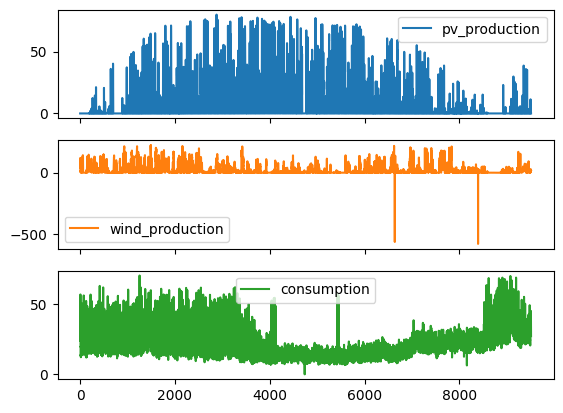

In [5]:

y[TARGET].plot(subplots = True); 

## Prepare the dataset

In [6]:
X_train_transformed[TARGET] = y

In [7]:
df = X_train_transformed

### Folds

In [321]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 4 months      #
# (3 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 24 * 7 * 16                             # 24 times a day * for 7 days * for 16 weeks


# --------------------------------------------------- #
# Let's consider FOLDS starting every 2 weeks         #
# --------------------------------------------------- #
    
FOLD_STRIDE = 24 * 7 * 2                              # 24 times a day for 2 weeks


# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_VAL_RATIO = 0.75                               # 3 month train, 1 month test

In [300]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    # YOUR CODE HERE
    folds = []
    for idx in range(0, len(df)-fold_length, fold_stride): # --> also possible to get rid of the break 
    #for idx in range(0, len(df), fold_stride):   # range(start, stop, step): for each idx in our rows at every 91 days
        # Exits the loop as soon as the last fold index would exceed the last index
        #if (idx + fold_length) > len(df):
            #break
        fold = df.iloc[idx:idx + fold_length, :]  # select from row idx til last row of the fold (3 years), all the columns
        folds.append(fold)   # append the 3 year fold to folds
    return folds

### Train-Val split

In [8]:
def train_val_split(fold:pd.DataFrame,
                     train_val_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    # YOUR CODE HERE
    # TRAIN SET
    # ======================
    last_train_idx = round(train_val_ratio * len(fold))  # 0.66 * number of rows in the fold (66% of the fold for train)
    fold_train = fold.iloc[0:last_train_idx, :]   # 1st until last row of train set, all columns

    # TEST SET
    # ======================    
    first_val_idx = last_train_idx - input_length  # last row of train set - 2 weeks --> test set starts 2 weeks 
                                                                    # before train set ends --> overlap (not a problem with X)
    fold_val = fold.iloc[first_val_idx:, :]   # 1st until last row of val set, all columns

    return (fold_train, fold_val)

In [305]:
(fold_train, fold_val) = train_val_split(folds[0], TRAIN_VAL_RATIO, INPUT_LENGTH)

In [145]:
#Five days as input & output length
INPUT_LENGTH = 24 * 5 # records every hour x 24 hours
                      # for 5 days
OUTPUT_LENGTH = 12

## Model

### Prepare dataset for model training

#### Train-Val split

In [18]:
def train_val_split(df:pd.DataFrame,
                     train_val_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    # YOUR CODE HERE
    # TRAIN SET
    # ======================
    last_train_idx = round(train_val_ratio * len(df))  # 0.66 * number of rows in the fold (66% of the fold for train)
    fold_train = df.iloc[0:last_train_idx, :]   # 1st until last row of train set, all columns

    # TEST SET
    # ======================    
    first_val_idx = last_train_idx - input_length  # last row of train set - 2 weeks --> test set starts 2 weeks 
                                                                    # before train set ends --> overlap (not a problem with X)
    fold_val = df.iloc[first_val_idx:, :]   # 1st until last row of val set, all columns

    return (fold_train, fold_val)

#### Sequences

In [10]:
#Five days as input & output length
INPUT_LENGTH = 24 * 5 # records every hour x 24 hours
                      # for 5 days
OUTPUT_LENGTH = 12

In [11]:
def get_Xi_yi(
    df:pd.DataFrame, 
    input_length:int,  # 120
    output_length:int):  # 120
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    # YOUR CODE
    first_possible_start = 0                                    # the +1 accounts for the index, that is exclusive.
    last_possible_start = len(df) - (input_length + output_length) + 1    # It can start as long as there are still 
                                                                             # 120 + 1 days after the 1st day.
    random_start = np.random.randint(first_possible_start, last_possible_start)  # np.random to pick a day inside 
                                                                                    # the possible interval.
    X_i = df.iloc[random_start:random_start+input_length]  
    
    y_i = df.iloc[random_start+input_length:
                  random_start+input_length+output_length][TARGET]  # creates a pd.DataFrame for the target y
    
    return (X_i, y_i)

In [15]:
TRAIN_VAL_RATIO = 0.75
NUMBER_OF_SEQUENCES_TRAIN = int(3000 * 0.75)   
NUMBER_OF_SEQUENCES_VAL = int(3000 * 0.25) 

In [16]:
def get_X_y(
    df:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int
):
    # YOUR CODE HERE
    X, y = [], []  # lists for the sequences for X and y

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(df, input_length, output_length)   # calls the previous function to generate sequences X + y
        X.append(Xi)
        y.append(yi)
        
    return np.array(X), np.array(y)

In [35]:
df_train, df_val = train_val_split(df, TRAIN_VAL_RATIO, INPUT_LENGTH)
X_train, y_train = get_X_y(df_train, NUMBER_OF_SEQUENCES_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_val, y_val = get_X_y(df_val, NUMBER_OF_SEQUENCES_VAL, INPUT_LENGTH, OUTPUT_LENGTH)


#Dropping the targets from the X (we dont want to train the model on the targets)
X_train = X_train[:, :, :-3]
X_val = X_val[:, :, :-3]

##### Show data

In [56]:
#Training set (splits the whole dataset into training and val set)
df_train.shape

(7136, 56)

In [57]:
#Validation set
df_val.shape

(2499, 56)

In [58]:
#Sequences of features of df_train (Splits the training set into smaller sequences with each shape of (120, 53))
# Train model on these features -> 53 features with 120 past hours
X_train.shape

(2250, 120, 53)

In [59]:
#Sequences of corresponding targets of df_train (Splits the training set into smaller sequences with each shape of (120, 3))
# Train model on these targets -> 3 targets with 12 next hours
y_train.shape

(2250, 12, 3)

In [60]:
#Sequences of features of df_val (Splits the val set into 750 sequences with each shape of (120, 53))
X_val.shape

(750, 120, 53)

In [61]:
#Sequences of corresponding targets of df_val (Splits the val set into 750 sequences with each shape of (120, 3))
y_val.shape

(750, 12, 3)

##### How do the dfs look like?

In [37]:
df_train

,minmaxscaler__hour_sine,minmaxscaler__hour_cosine,minmaxscaler__month_sine,minmaxscaler__month_cosine,minmaxscaler__season_sine,minmaxscaler__season_cosine,minmaxscaler__precip_1h:mm,minmaxscaler__prob_precip_1h:p,minmaxscaler__clear_sky_rad:W,minmaxscaler__clear_sky_energy_1h:J,...,robustscaler__wind_speed_10m:ms,robustscaler__wind_speed_50m:ms,robustscaler__wind_speed_100m:ms,onehotencoder__precip_type:idx_0.0,onehotencoder__precip_type:idx_1.0,onehotencoder__precip_type:idx_2.0,onehotencoder__precip_type:idx_3.0,pv_production,wind_production,consumption
0,0.370590,0.017037,0.750000,0.933013,0.5,1.0,0.0,0.0,0.757424,0.854846,...,0.912001,0.919976,0.936622,1.0,0.0,0.0,0.0,0.0,40.59,26.514689
1,0.250000,0.066987,0.750000,0.933013,0.5,1.0,0.0,0.0,0.000000,0.779972,...,0.845489,0.859477,0.887809,1.0,0.0,0.0,0.0,0.0,67.86,28.326960
2,0.146447,0.146447,0.750000,0.933013,0.5,1.0,0.0,0.0,0.000000,0.000000,...,1.111203,1.085550,1.083210,1.0,0.0,0.0,0.0,0.0,116.68,23.682207
3,0.066987,0.250000,0.750000,0.933013,0.5,1.0,0.0,0.0,0.000000,0.000000,...,1.434093,1.372530,1.332958,1.0,0.0,0.0,0.0,0.0,120.22,25.354782
4,0.017037,0.370590,0.750000,0.933013,0.5,1.0,0.0,0.0,0.000000,0.000000,...,1.375834,1.330847,1.297649,1.0,0.0,0.0,0.0,0.0,109.86,23.861942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7131,0.066987,0.250000,0.066987,0.750000,0.0,0.5,0.0,0.0,0.000000,0.789028,...,0.086402,0.000000,-0.105984,1.0,0.0,0.0,0.0,0.0,-0.33,22.159622
7132,0.017037,0.370590,0.066987,0.750000,0.0,0.5,0.0,0.0,0.000000,0.000000,...,-0.246347,-0.316057,-0.383700,1.0,0.0,0.0,0.0,0.0,-0.34,24.798298
7133,0.000000,0.500000,0.066987,0.750000,0.0,0.5,0.0,0.0,0.000000,0.000000,...,-0.045545,-0.130643,-0.252573,1.0,0.0,0.0,0.0,0.0,-0.36,30.817582
7134,0.017037,0.629410,0.066987,0.750000,0.0,0.5,0.0,0.0,0.000000,0.000000,...,-0.302016,-0.398752,-0.491991,1.0,0.0,0.0,0.0,0.0,-0.30,26.371867


In [39]:
df_val

,minmaxscaler__hour_sine,minmaxscaler__hour_cosine,minmaxscaler__month_sine,minmaxscaler__month_cosine,minmaxscaler__season_sine,minmaxscaler__season_cosine,minmaxscaler__precip_1h:mm,minmaxscaler__prob_precip_1h:p,minmaxscaler__clear_sky_rad:W,minmaxscaler__clear_sky_energy_1h:J,...,robustscaler__wind_speed_10m:ms,robustscaler__wind_speed_50m:ms,robustscaler__wind_speed_100m:ms,onehotencoder__precip_type:idx_0.0,onehotencoder__precip_type:idx_1.0,onehotencoder__precip_type:idx_2.0,onehotencoder__precip_type:idx_3.0,pv_production,wind_production,consumption
7016,0.146447,0.853553,0.066987,0.750000,0.0,0.5,0.0,0.0,0.0,0.0,...,-0.624904,-0.741295,-0.941294,1.0,0.0,0.0,0.0,0.0,9.84,27.835067
7017,0.250000,0.933013,0.066987,0.750000,0.0,0.5,0.0,0.0,0.0,0.0,...,-0.624904,-0.686177,-0.837521,1.0,0.0,0.0,0.0,0.0,12.59,19.498231
7018,0.370590,0.982963,0.066987,0.750000,0.0,0.5,0.0,0.0,0.0,0.0,...,-0.485613,-0.487358,-0.454837,1.0,0.0,0.0,0.0,0.0,22.86,16.549779
7019,0.500000,1.000000,0.066987,0.750000,0.0,0.5,0.0,0.0,0.0,0.0,...,-0.360275,-0.276690,-0.221841,1.0,0.0,0.0,0.0,0.0,6.29,20.053793
7020,0.629410,0.982963,0.066987,0.750000,0.0,0.5,0.0,0.0,0.0,0.0,...,-0.360275,-0.316057,-0.252573,1.0,0.0,0.0,0.0,0.0,8.44,20.168304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9510,0.017037,0.629410,0.750000,0.933013,0.5,1.0,0.0,0.0,0.0,0.0,...,0.205763,0.226072,0.252054,1.0,0.0,0.0,0.0,0.0,21.98,44.422658
9511,0.066987,0.750000,0.750000,0.933013,0.5,1.0,0.0,0.0,0.0,0.0,...,0.205763,0.251639,0.292863,1.0,0.0,0.0,0.0,0.0,9.60,45.167707
9512,0.146447,0.853553,0.750000,0.933013,0.5,1.0,0.0,0.0,0.0,0.0,...,0.127466,0.199967,0.252054,1.0,0.0,0.0,0.0,0.0,22.61,32.476198
9513,0.250000,0.933013,0.750000,0.933013,0.5,1.0,0.0,0.0,0.0,0.0,...,0.086402,0.146047,0.209862,1.0,0.0,0.0,0.0,0.0,21.70,28.561791


In [41]:
X_train

array([[[0.14644661, 0.85355339, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.25      , 0.9330127 , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.37059048, 0.98296291, 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.5       , 0.0669873 , ..., 0.        ,
         0.        , 0.        ],
        [0.01703709, 0.62940952, 0.0669873 , ..., 0.        ,
         0.        , 0.        ],
        [0.0669873 , 0.75      , 0.0669873 , ..., 0.        ,
         0.        , 0.        ]],

       [[0.01703709, 0.37059048, 0.9330127 , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.5       , 0.9330127 , ..., 0.        ,
         0.        , 0.        ],
        [0.01703709, 0.62940952, 0.9330127 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.25      , 0.0669873 , 1.        , ..., 0.        ,
         0.        , 0.        ],
        [0.1

In [43]:
y_train

array([[[ 0.00000000e+00, -2.50000000e-01,  2.01589867e+01],
        [ 0.00000000e+00, -2.40000000e-01,  1.14855933e+01],
        [ 0.00000000e+00, -2.40000000e-01,  7.91753500e+00],
        ...,
        [ 4.69658320e+00,  3.20700000e+01,  1.91948489e+01],
        [ 2.56067500e+01,  6.61500000e+01,  1.90871978e+01],
        [ 4.03999160e+01,  4.54600000e+01,  1.92594511e+01]],

       [[ 0.00000000e+00,  7.78800000e+01,  2.23920422e+01],
        [ 0.00000000e+00,  9.82200000e+01,  5.81534222e+01],
        [ 0.00000000e+00,  8.96200000e+01,  4.77380222e+01],
        ...,
        [ 0.00000000e+00,  2.49700000e+01,  2.66239356e+01],
        [ 0.00000000e+00,  1.94200000e+01,  2.61866644e+01],
        [ 0.00000000e+00,  1.48300000e+01,  2.51457422e+01]],

       [[ 4.50604170e+01, -0.00000000e+00,  1.58383333e+01],
        [ 5.72908340e+01, -0.00000000e+00,  1.24288600e+01],
        [ 6.60800840e+01, -0.00000000e+00,  1.05990067e+01],
        ...,
        [ 2.58024170e+01, -0.00000000e+00,

In [45]:
X_val

array([[[0.62940952, 0.98296291, 0.5       , ..., 0.        ,
         0.        , 0.        ],
        [0.75      , 0.9330127 , 0.5       , ..., 0.        ,
         0.        , 0.        ],
        [0.85355339, 0.85355339, 0.5       , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.25      , 0.9330127 , 0.5       , ..., 0.        ,
         0.        , 0.        ],
        [0.37059048, 0.98296291, 0.5       , ..., 0.        ,
         0.        , 0.        ],
        [0.5       , 1.        , 0.5       , ..., 0.        ,
         0.        , 0.        ]],

       [[0.25      , 0.9330127 , 0.25      , ..., 0.        ,
         0.        , 0.        ],
        [0.37059048, 0.98296291, 0.25      , ..., 0.        ,
         0.        , 0.        ],
        [0.5       , 1.        , 0.25      , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.01703709, 0.62940952, 0.25      , ..., 0.        ,
         0.        , 0.        ],
        [0.0

In [47]:
y_val

array([[[ 0.00000000e+00,  2.06500000e+01,  2.00543022e+01],
        [ 0.00000000e+00,  2.91900000e+01,  1.78826067e+01],
        [ 0.00000000e+00,  2.46700000e+01,  1.98055756e+01],
        ...,
        [ 9.19167000e-02,  9.28000000e+00,  1.69353156e+01],
        [ 3.33340000e-03,  8.01000000e+00,  1.75387989e+01],
        [ 1.64083300e-01,  5.83000000e+00,  1.92496711e+01]],

       [[ 0.00000000e+00, -3.10000000e-01,  1.74297622e+01],
        [ 0.00000000e+00,  2.95000000e+00,  1.73931400e+01],
        [ 0.00000000e+00,  2.38000000e+00,  1.73617000e+01],
        ...,
        [ 3.78182000e-02,  1.31200000e+01,  2.70674578e+01],
        [ 6.45750000e-01,  5.44000000e+00,  2.97449111e+01],
        [ 2.51175000e+00,  1.74000000e+00,  2.53388800e+01]],

       [[ 0.00000000e+00, -4.00000000e-01,  2.71397933e+01],
        [ 0.00000000e+00, -3.60000000e-01,  2.88521733e+01],
        [ 3.37583400e-01, -4.70000000e-01,  2.85557200e+01],
        ...,
        [ 0.00000000e+00,  1.41900000e+01,

### Train model on mini sequences

In [84]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2

def init_model(X_train, y_train):

    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()
    
    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(64, 
                          activation='tanh', 
                          return_sequences = True,
                          input_shape=(120, 53)
                          
                         ))
    
    model.add(layers.LSTM(units=32, activation='tanh', return_sequences = True))

    ## 1.2 Hidden layer
    model.add(layers.Dense(10, activation="linear"))

    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length*3, activation='linear'))  # Flatten the output
    model.add(layers.Reshape((output_length, 3)))  # Reshape to (12, 3)


    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.005)    
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model

In [81]:
def init_model(X_train, y_train):

    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()
    
    ## 1.1 - Recurrent Layers
    model.add(layers.LSTM(64, 
                          activation='tanh', 
                          return_sequences=True,  # Keep output for each time step
                          input_shape=(120, 53)))
    
    model.add(layers.LSTM(32, 
                          activation='tanh', 
                          return_sequences=True))  # Keep the sequence dimension

    ## 1.2 - Hidden Dense Layer
    model.add(layers.TimeDistributed(layers.Dense(64, activation="relu")))  # Apply to each time step
    
    ## 1.3 - Predictive Dense Layer
    output_length = y_train.shape[1]  # 12 future steps
    num_targets = y_train.shape[2]    # 3 targets
    model.add(layers.TimeDistributed(layers.Dense(num_targets, activation='linear')))  # Directly output 3 targets

    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.005)    
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model


In [85]:
model = init_model(X_train, y_train)
model.summary()

ValueError: Exception encountered when calling layer "reshape_7" (type Reshape).

total size of new array must be unchanged, input_shape = [120, 36], output_shape = [12, 3]

Call arguments received by layer "reshape_7" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 120, 36), dtype=float32)

In [83]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from typing import Tuple

def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 10,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(seq[0], seq[1],
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 32,
                        epochs = 500,
                        callbacks = [es],
                        verbose = verbose)

    return model, history 

In [386]:
model = init_model(X_train, y_train)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (None, 120, 64)           30976     
                                                                 
 lstm_97 (LSTM)              (None, 32)                12416     
                                                                 
 dense_114 (Dense)           (None, 10)                330       
                                                                 
 dense_115 (Dense)           (None, 36)                396       
                                                                 
 reshape_23 (Reshape)        (None, 12, 3)             0         
                                                                 
Total params: 44,118
Trainable params: 44,118
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
206/206 [=============================

In [394]:
y_pred = model.predict(seq[0])
y_pred.shape

294/294 [==============================] - 8s 21ms/step


(9383, 12, 3)

In [395]:
y_pred

array([[[-0.8020408 , 18.34753   , 21.33138   ],
        [-0.9647536 , 18.421618  , 21.122456  ],
        [-1.3415666 , 20.005928  , 20.493855  ],
        ...,
        [ 0.60888636, 26.567987  , 19.81623   ],
        [ 1.6607935 , 26.492733  , 20.42729   ],
        [ 3.0801427 , 26.170689  , 20.574432  ]],

       [[39.73488   , 44.104004  , 15.075556  ],
        [36.759144  , 49.78342   , 15.790366  ],
        [32.116085  , 57.46399   , 15.487595  ],
        ...,
        [-2.5340815 , 78.68107   , 16.51992   ],
        [-3.1514244 , 75.04531   , 14.823896  ],
        [-1.9327254 , 70.93645   , 12.849353  ]],

       [[ 1.7809284 ,  9.646585  , 19.621975  ],
        [ 1.6718595 , 10.026352  , 19.437092  ],
        [ 1.554491  , 10.751839  , 18.943169  ],
        ...,
        [-0.86131895, 14.355082  , 17.919018  ],
        [-0.12621427, 14.562532  , 18.513962  ],
        [ 1.5860507 , 14.57845   , 18.489445  ]],

       ...,

       [[ 2.7598376 , 12.230527  , 14.097349  ],
        [ 1

## Cross Validation

### Sequences

In [338]:
def get_Xi_yi(
    df:pd.DataFrame, 
    input_length:int,  # 120
    output_length:int):  # 120
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    # YOUR CODE
    first_possible_start = 0                                    # the +1 accounts for the index, that is exclusive.
    last_possible_start = len(df) - (input_length + output_length) + 1    # It can start as long as there are still 
                                                                             # 120 + 1 days after the 1st day.
    random_start = np.random.randint(first_possible_start, last_possible_start)  # np.random to pick a day inside 
                                                                                    # the possible interval.
    X_i = df.iloc[random_start:random_start+input_length]  
    
    y_i = df.iloc[random_start+input_length:
                  random_start+input_length+output_length][TARGET]  # creates a pd.DataFrame for the target y
    
    return (X_i, y_i)

In [312]:
#Testing if the function works
Xi, Yi = get_Xi_yi(
    fold=folds[0], 
    input_length=INPUT_LENGTH,
    output_length=OUTPUT_LENGTH)

In [400]:
Xi.shape

(120, 53)

In [265]:
### In the recap they choose a number which is bigger than the number of rows in the fold -> does that mean there are duplications???!!!
NUMBER_OF_SEQUENCES_TRAIN = (FOLD_LENGTH - (INPUT_LENGTH + OUTPUT_LENGTH))
NUMBER_OF_SEQUENCES_VAL = (FOLD_LENGTH - (INPUT_LENGTH + OUTPUT_LENGTH))

In [339]:
NUMBER_OF_SEQUENCES_TRAIN = len(df) - (INPUT_LENGTH + OUTPUT_LENGTH)

In [399]:
NUMBER_OF_SEQUENCES_TRAIN

9383

In [340]:
def get_X_y(
    df:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int
):
    # YOUR CODE HERE
    X, y = [], []  # lists for the sequences for X and y

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(df, input_length, output_length)   # calls the previous function to generate sequences X + y
        X.append(Xi)
        y.append(yi)
        
    return np.array(X), np.array(y)

In [342]:
seq = get_X_y(df, NUMBER_OF_SEQUENCES_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)

In [384]:
seq[1].shape

(9383, 12, 3)

In [268]:
X_train.shape

(2556, 120, 53)

In [269]:
y_train.shape

(2556, 12, 3)

In [326]:
y_temp = y_train[:,:,0]

In [327]:
y_temp = np.expand_dims(y_temp, axis=-1)

In [328]:
y_temp.shape

(2556, 12, 1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def cross_validate_baseline_and_lstm():
    '''
    This function cross-validates 
    - the "last seen value" baseline model
    - the RNN model
    '''
    
    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []
    
    # 0 - Creating folds
    # =========================================    
    folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)  # function we coded to get the folds
    
    for fold_id, fold in enumerate(folds):
        
        # 1 - Train/val split the current fold
        # =========================================
        (fold_train, fold_val) = train_val_split(fold, TRAIN_VAL_RATIO, INPUT_LENGTH) # function we coded to split train/val                                 

        X_train, y_train = get_X_y(fold_train, NUMBER_OF_SEQUENCES_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)  # function we coded to get multiple
        X_val, y_val = get_X_y(fold_val, NUMBER_OF_SEQUENCES_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)       # sequences from a fold
        
        # 2 - Modelling
        # =========================================
        
        ##### Baseline Model
        baseline_model = init_baseline()
        mae_baseline = baseline_model.evaluate(X_val, y_val, verbose=0)[1]   # evaluating baseline model (metric)
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = init_model(X_train, y_train)
        es = EarlyStopping(monitor = "val_mae",
                           mode = "min",
                           patience = 3, 
                           restore_best_weights = True)
        
        history = model.fit(X_train, y_train,
                            validation_split = 0.3,
                            shuffle = False,
                            batch_size = 32,
                            epochs = 50,
                            callbacks = [es],
                            verbose = 0)
        res = model.evaluate(X_val, y_val, verbose=0)    # evaluating LSTM (metric)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")
        
        ##### Comparison LSTM vs Baseline for the current fold
        print(f"🏋🏽‍♂️ improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model

In [ ]:
###NOT IMPORTANT NOW

fold_length = 24 * 7 * 16    # 24 hours * 7 days * 16 weeks (4 months)
fold_stride = 24 * 7 * 2     # 24 hours * 7 days * 2 weeks
train_test_ratio = 0.66

In [ ]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    # YOUR CODE HERE
    folds = []
    for idx in range(0, len(df)-fold_length, fold_stride): # --> also possible to get rid of the break 
    #for idx in range(0, len(df), fold_stride):   # range(start, stop, step): for each idx in our rows at every 91 days
        # Exits the loop as soon as the last fold index would exceed the last index
        #if (idx + fold_length) > len(df):
            #break
        fold = df.iloc[idx:idx + fold_length, :]  # select from row idx til last row of the fold (3 years), all the columns
        folds.append(fold)   # append the 3 year fold to folds
    return folds